In [1]:
%pip install 'chronos-forecasting>=2.0' 'pandas[pyarrow]' 'matplotlib' --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

# Use only 1 GPU if available
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-2", 
    # device_map="cuda"
        device_map="cpu")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [2]:
import pandas as pd
import holidays

def add_holiday_flags(
    df: pd.DataFrame,
    ts_col: str = "ds",
    local_tz: str = "America/Montreal",
    observed: bool = True,
    include_names: bool = False,
) -> pd.DataFrame:
    """
    Adds boolean columns:
      • is_qc_holiday       — Québec public holiday (CA-QC)
      • is_jewish_holiday   — Israeli public/Jewish holiday (IL)
    Optionally adds:
      • qc_holiday_name
      • jewish_holiday_name

    Notes:
      • Holiday checks are date-based (00:00–24:00 local calendar date),
        not sundown-to-sundown observance.
      • NaT timestamps are ignored gracefully.
    """
    out = df.copy()

    # 1) Parse to datetime
    out[ts_col] = pd.to_datetime(out[ts_col], errors="coerce")

    # 2) Get the calendar DATE to use for holiday lookup
    #    - If tz-aware: convert to Montreal then take .date
    #    - If naive: assume values already represent local Montreal wall-clock; just take .date
    if getattr(out[ts_col].dt, "tz", None) is not None:
        dates_for_calendar = out[ts_col].dt.tz_convert(local_tz).dt.date
    else:
        dates_for_calendar = out[ts_col].dt.date

    # 3) Build a SAFE integer year range for the holiday objects
    years_series = pd.Series(dates_for_calendar)
    years_series = years_series.dropna().map(lambda d: int(pd.Timestamp(d).year))
    if years_series.empty:
        raise ValueError("No valid datetimes found to extract holiday years.")
    years = list(range(int(years_series.min()), int(years_series.max()) + 1))

    # 4) Construct holiday calendars
    qc_holidays = holidays.Canada(subdiv="QC", years=years, observed=observed)
    il_holidays = holidays.Israel(years=years, observed=observed)

    # 5) Flag membership
    out["is_qc_holiday"] = [ (d in qc_holidays) if pd.notna(pd.Timestamp(d)) else False
                             for d in dates_for_calendar ]
    out["is_jewish_holiday"] = [ (d in il_holidays) if pd.notna(pd.Timestamp(d)) else False
                                 for d in dates_for_calendar ]

    if include_names:
        out["qc_holiday_name"] = [ qc_holidays.get(d, "") if pd.notna(pd.Timestamp(d)) else ""
                                   for d in dates_for_calendar ]
        out["jewish_holiday_name"] = [ il_holidays.get(d, "") if pd.notna(pd.Timestamp(d)) else ""
                                       for d in dates_for_calendar ]

    return out


In [12]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/s83jig4zews1xz7vhezui/allDataWithCalculatedColumns.csv?rlkey=9mm4zwaugxyj2r4ooyd39y4nl&raw=1')
df.ds = pd.to_datetime(df.ds, errors="coerce")
df.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_CONS_MORE2H,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow
42505,2025-11-10 09:00:00,11,33,8,22,19,55,4,9,0,...,5,0,2,1,14,11,15,13,2,6
42506,2025-11-10 10:00:00,9,42,9,31,18,73,3,12,0,...,2,0,2,1,14,11,21,19,2,6
42507,2025-11-10 11:00:00,15,57,11,42,26,99,6,18,0,...,3,0,2,1,14,11,31,28,3,6
42508,2025-11-10 12:00:00,13,70,17,59,30,129,2,20,0,...,6,0,2,0,14,11,45,43,2,6
42509,2025-11-10 13:00:00,11,81,7,66,18,147,7,27,0,...,7,0,1,0,14,11,51,48,3,13


In [ ]:
df = add_holiday_flags(df, ts_col="ds")
df.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow,is_qc_holiday,is_jewish_holiday
0,2021-01-01 01:00:00,1,1,1,1,2,2,0,0,0,...,0,0,3,3,0,0,0,0,True,False
1,2021-01-01 02:00:00,2,3,1,2,3,5,1,1,0,...,0,0,3,3,3,2,1,0,True,False
2,2021-01-01 03:00:00,0,3,1,3,1,6,0,1,0,...,0,0,3,3,2,1,1,0,True,False
3,2021-01-01 04:00:00,1,4,0,3,1,7,1,2,0,...,0,0,4,3,1,0,1,0,True,False
4,2021-01-01 05:00:00,1,5,1,4,2,9,1,3,0,...,0,0,4,3,2,1,1,0,True,False


In [14]:
df['id']='jgh'
df.head()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow,is_qc_holiday,is_jewish_holiday,id
0,2021-01-01 01:00:00,1,1,1,1,2,2,0,0,0,...,0,3,3,0,0,0,0,True,False,jgh
1,2021-01-01 02:00:00,2,3,1,2,3,5,1,1,0,...,0,3,3,3,2,1,0,True,False,jgh
2,2021-01-01 03:00:00,0,3,1,3,1,6,0,1,0,...,0,3,3,2,1,1,0,True,False,jgh
3,2021-01-01 04:00:00,1,4,0,3,1,7,1,2,0,...,0,4,3,1,0,1,0,True,False,jgh
4,2021-01-01 05:00:00,1,5,1,4,2,9,1,3,0,...,0,4,3,2,1,1,0,True,False,jgh


In [6]:
import pandas as pd
import os

# List of METAR CSV files
metar_files = [f for f in os.listdir('.') if f.startswith('metar') and f.endswith('.csv')]

# Load and concatenate the dataframes
metar_dfs = []
for file in metar_files:
    try:
        df_temp = pd.read_csv(file)
        metar_dfs.append(df_temp)
    except Exception as e:
        print(f"Error loading {file}: {e}")

metar_df = pd.concat(metar_dfs, ignore_index=True)

# Display the merged dataframe
print("Merged METAR dataframe shape:", metar_df.shape)
display(metar_df.tail())

metar_df['valid'] = pd.to_datetime(metar_df['valid'], errors="coerce")
#sort by valid, ascending
metar_df = metar_df.sort_values(by='valid', ascending=True)
metar_df.tail()

#rename the valid column of metar_df to ds
metar_df = metar_df.rename(columns={'valid': 'ds'})
#join df and metar_df on ds
df = pd.merge(df, metar_df, on='ds', how='left')
df.tail()

ValueError: No objects to concatenate

In [15]:
import pandas as pd
from pandas.tseries.frequencies import to_offset

ID_COL = "id"
TS_COL = "ds"
TARGETS = ['total_tbs','overflow','Inflow_Total']

df = df.copy()
df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce")
df = df.dropna(subset=[TS_COL])

# Snap to exact hours (lowercase 'h' to avoid FutureWarning)
df[TS_COL] = df[TS_COL].dt.floor("h")

# Sort + dedupe
df = df.sort_values([ID_COL, TS_COL]).drop_duplicates([ID_COL, TS_COL], keep="last")

def regularize_hourly(g: pd.DataFrame) -> pd.DataFrame:
    """
    Reindex each group's timestamps to strict hourly and fill gaps.
    Works whether the grouping column is present or omitted (include_groups=False).
    """
    # The group key (id) is available as g.name; if ID_COL exists, prefer it.
    sid = g[ID_COL].iloc[0] if ID_COL in g.columns else g.name

    g = g.sort_values(TS_COL)
    full_idx = pd.date_range(g[TS_COL].min(), g[TS_COL].max(), freq="h")
    g = g.set_index(TS_COL).reindex(full_idx)
    g.index.name = TS_COL

    # restore id (constant for the whole group)
    g[ID_COL] = sid

    # numeric + fill for targets
    for col in TARGETS:
        if col in g.columns:
            g[col] = pd.to_numeric(g[col], errors="coerce").ffill().bfill()
    return g.reset_index()

# Call apply with include_groups=False if supported; else fall back
gb = df.groupby(ID_COL, group_keys=False)
try:
    df = gb.apply(regularize_hourly, include_groups=False)
except TypeError:
    # older pandas without include_groups
    df = gb.apply(regularize_hourly)

# Assert truly hourly (accept 'h' and 'H')
g = df[df[ID_COL] == "jgh"].sort_values(TS_COL)
freq = pd.infer_freq(g[TS_COL])
if not freq:
    raise ValueError("No inferable frequency after regularization.")
if to_offset(freq).name.lower() != "h":
    # extra check independent of infer_freq
    diffs = g[TS_COL].diff().dropna()
    bad = g.loc[diffs != pd.Timedelta(hours=1), TS_COL].head(10).tolist()
    raise ValueError(f"Non-1h gaps remain around: {bad}")



In [16]:
# Predict
pred_df = pipeline.predict_df(
    df,
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=ID_COL,
    timestamp_column=TS_COL,
    target=TARGETS,
)
pred_df.head()

,id,ds,target_name,predictions,0.1,0.5,0.9
0,jgh,2025-11-10 14:00:00,total_tbs,53.358040,47.527695,53.358040,57.879478
1,jgh,2025-11-10 15:00:00,total_tbs,53.606827,45.896454,53.606827,59.653465
2,jgh,2025-11-10 16:00:00,total_tbs,54.433578,45.564369,54.433578,62.065388
3,jgh,2025-11-10 17:00:00,total_tbs,48.773193,38.130054,48.773193,57.695171
4,jgh,2025-11-10 18:00:00,total_tbs,44.777466,32.493343,44.777466,55.063530


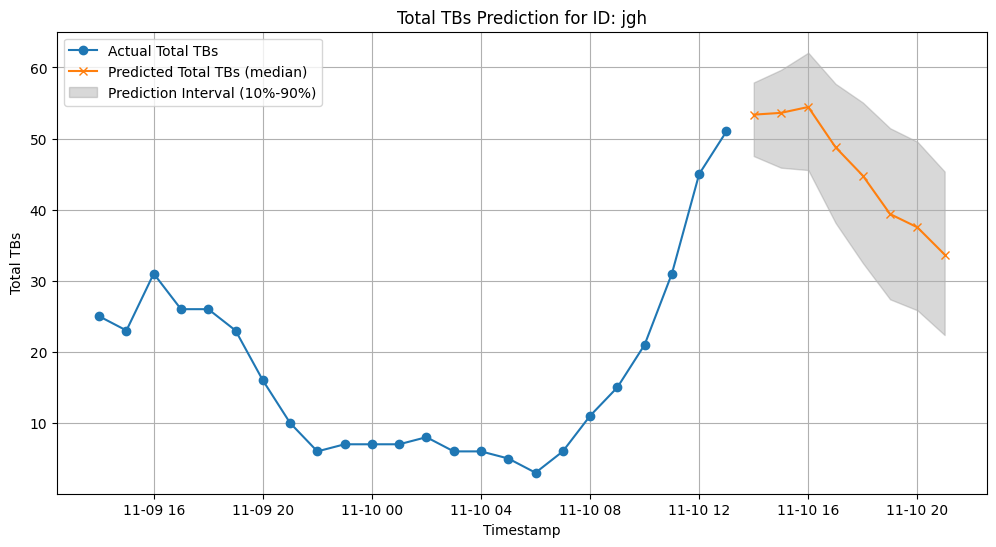

In [17]:
# make a graph of the next 8 hours of predictions of total_tbs, along with the last 24 hours of actual total_tbs
# (matplotlib is already imported earlier in the notebook; no need to re-import)
# Filter for the specific id and target_name == 'total_tbs'
id_to_plot = "jgh"
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)

# pred_df stores quantiles in columns '0.1','0.5','0.9' and has a 'target_name' column.
predicted_data = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "total_tbs")
].set_index(TS_COL)

# Ensure predicted rows are sorted by timestamp
predicted_data = predicted_data.sort_index()

# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["total_tbs"][-24:], label="Actual Total TBs", marker="o")

# Plot the next 8 hours of predicted median (0.5) and fill 10%-90% interval
plt.plot(predicted_data.index[:8], predicted_data["0.5"][:8], label="Predicted Total TBs (median)", marker="x")
plt.fill_between(
    predicted_data.index[:8],
    predicted_data["0.1"][:8],
    predicted_data["0.9"][:8],
    color="gray",
    alpha=0.3,
    label="Prediction Interval (10%-90%)",
)

plt.xlabel("Timestamp")
plt.ylabel("Total TBs")
plt.title(f"Total TBs Prediction for ID: {id_to_plot}")
plt.legend()
plt.grid()
plt.show()


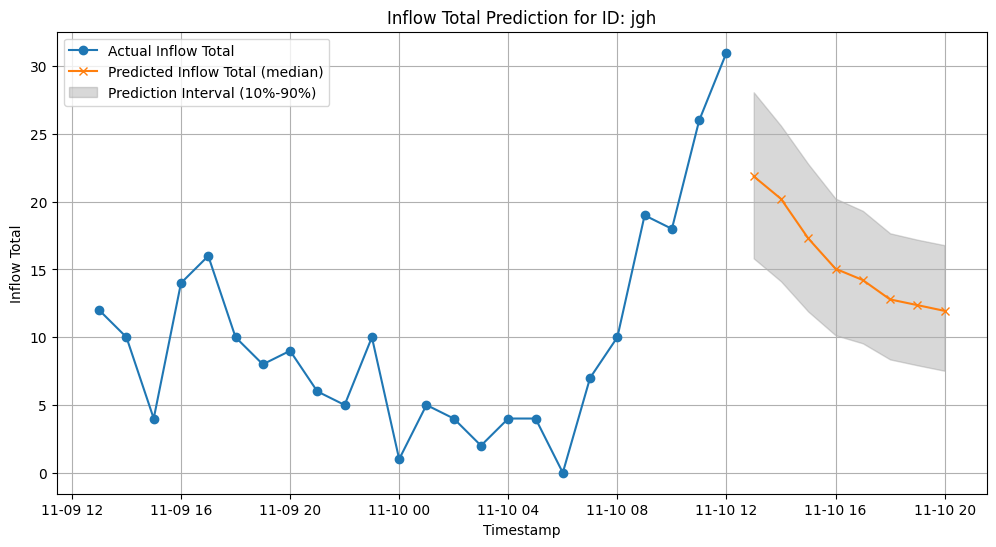

In [11]:
#plot the last 24 hours of Inflow_Total, along with the next 8 hours of predictions
# Filter for the specific id and target_name == 'Inflow_Total'
id_to_plot = "jgh"
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)
predicted_data = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "Inflow_Total")
].set_index(TS_COL)
# Ensure predicted rows are sorted by timestamp
predicted_data = predicted_data.sort_index()    
# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["Inflow_Total"][-24:], label="Actual Inflow Total", marker="o")
# Plot the next 8 hours of predicted median (0.5) and fill 10%-90% interval
plt.plot(predicted_data.index[:8], predicted_data["0.5"][:8], label="Predicted Inflow Total (median)", marker="x")
plt.fill_between(
    predicted_data.index[:8],
    predicted_data["0.1"][:8],
    predicted_data["0.9"][:8],
    color="gray",
    alpha=0.3,
    label="Prediction Interval (10%-90%)",
)
plt.xlabel("Timestamp")
plt.ylabel("Inflow Total")
plt.title(f"Inflow Total Prediction for ID: {id_to_plot}")
plt.legend()
plt.grid()
plt.show()